Import Dependencies

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 16.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import gc # Garbage Collector interface

In [ ]:
# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# Suppress Optuna's logging to keep the output clean during optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)

Part 2: Data Ingestion and Memory Optimization

In [ ]:
# Define a function to reduce memory usage of a DataFrame
def reduce_mem_usage(df, verbose=True):
    """
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype
        if col_type!= object and col_type.name!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage after optimization is: {end_mem:.2f} MB')
        print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')

    return df

In [ ]:
import pandas as pd
flights_df = pd.read_csv('flights.csv')

file_path = 'flights.csv'

Define columns to use ---
We exclude columns that are either identifiers, redundant, or cause data leakage.
-Leaky columns: CANCELLATION_REASON and the 5 delay breakdown columns.
-Other dropped: YEAR (only 2015), TAIL_NUMBER, FLIGHT_NUMBER (identifiers),
DEPARTURE_TIME, TAXI_IN, WHEELS_OFF, WHEELS_ON, ARRIVAL_TIME, ELAPSED_TIME, AIR_TIME
These are actuals, not known beforehand. We use scheduled times.

In [ ]:
columns_to_use = [
    'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
    'SCHEDULED_TIME', 'DISTANCE', 'DIVERTED',
    'CANCELLED', 'ARRIVAL_DELAY', 'DEPARTURE_DELAY'
]

#Load data with selected columns and apply memory reduction ---
print("Loading and optimizing the dataset...")
# On the full dataset, this step is crucial.
flights_df = pd.read_csv(file_path, usecols=columns_to_use)
print("Columns after loading:", flights_df.columns) # Added print statement
flights_df = reduce_mem_usage(flights_df)

Loading and optimizing the dataset...
Columns after loading: Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY',
       'DIVERTED', 'CANCELLED'],
      dtype='object')
Memory usage of dataframe is 21.33 MB
Memory usage after optimization is: 10.49 MB
Decreased by 50.8%


Data Cleaning and Preprocessing

Step 1: Handle Missing Values

In [ ]:
import pandas as pd # Import pandas again to be safe
# Re-load the data with the necessary columns for cleaning
columns_for_cleaning = [
    'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
    'SCHEDULED_TIME', 'DISTANCE', 'DIVERTED',
    'CANCELLED', 'ARRIVAL_DELAY', 'DEPARTURE_DELAY'
]
flights_df = pd.read_csv('flights.csv', usecols=columns_for_cleaning)

# --- Step 1: Handle Missing Values ---
# Drop rows where the target variable 'ARRIVAL_DELAY' is missing.
# These are often cancelled or diverted flights which we are not predicting.
flights_df.dropna(subset=['ARRIVAL_DELAY'], inplace=True)

# Impute missing values for key predictors with the median.
# Median is more robust to outliers than the mean.
median_dep_delay = flights_df['DEPARTURE_DELAY'].median()
flights_df['DEPARTURE_DELAY'] = flights_df['DEPARTURE_DELAY'].fillna(median_dep_delay).copy() # Added .copy()


# --- Step 2: Filter out Cancelled and Diverted Flights ---
# The prediction task is for completed flights.
# Perform filtering before dropping the columns
flights_df = flights_df[(flights_df['CANCELLED'] == 0) & (flights_df['DIVERTED'] == 0)].copy() # Use .copy() to avoid SettingWithCopyWarning

# --- Step 3: Drop Columns with High Missing Values and Data Leakage ---
# Columns with too many missing values or that are not useful
# Note: Some columns from the original list are not present in the reduced DataFrame
# after initial loading with usecols. We only drop columns that exist.
cols_to_drop = [
    'DIVERTED', # Already filtered out, but good to drop the column
    'CANCELLED' # Already filtered out, but good to drop the column
    # Add other columns to drop if necessary based on your analysis
    # For example, if any of the originally intended leaky columns were accidentally loaded
]
# Check if columns exist before dropping
cols_to_drop_existing = [col for col in cols_to_drop if col in flights_df.columns]
flights_df.drop(columns=cols_to_drop_existing, inplace=True)


print(f"Dataset shape after cleaning: {flights_df.shape}")
print(f"Remaining missing values:\n{flights_df.isnull().sum()}")

/tmp/ipython-input-2395349796.py:9: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv('flights.csv', usecols=columns_for_cleaning)


Dataset shape after cleaning: (242433, 13)
Remaining missing values:
YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_DELAY        0
SCHEDULED_TIME         0
DISTANCE               0
SCHEDULED_ARRIVAL      0
ARRIVAL_DELAY          0
dtype: int64


 Feature Engineering

In [ ]:
# --- Create new features from existing ones ---

# Convert scheduled departure time to datetime objects to extract features
# We will create a temporary column to handle the format
def format_time(t):
    t = int(t)
    if t == 2400:
        return '0000'
    else:
        return f"{t:04d}"

flights_df['SCHEDULED_DEPARTURE_FORMATTED'] = flights_df['SCHEDULED_DEPARTURE'].apply(format_time)

# Extract hour and minute
flights_df['DEPARTURE_HOUR'] = pd.to_datetime(flights_df['SCHEDULED_DEPARTURE_FORMATTED'], format='%H%M').dt.hour
flights_df['DEPARTURE_MINUTE'] = pd.to_datetime(flights_df['SCHEDULED_DEPARTURE_FORMATTED'], format='%H%M').dt.minute
flights_df.drop(columns=['SCHEDULED_DEPARTURE_FORMATTED'], inplace=True)


# Combine origin and destination to create a route feature
flights_df['ROUTE'] = flights_df['ORIGIN_AIRPORT'] + '-' + flights_df['DESTINATION_AIRPORT']


print("New features created: DEPARTURE_HOUR, DEPARTURE_MINUTE, ROUTE")
print(flights_df[['SCHEDULED_DEPARTURE', 'DEPARTURE_HOUR', 'DEPARTURE_MINUTE', 'ROUTE']].head())

New features created: DEPARTURE_HOUR, DEPARTURE_MINUTE, ROUTE
   SCHEDULED_DEPARTURE  DEPARTURE_HOUR  DEPARTURE_MINUTE    ROUTE
0                    5               0                 5  ANC-SEA
1                   10               0                10  LAX-PBI
2                   20               0                20  SFO-CLT
3                   20               0                20  LAX-MIA
4                   25               0                25  SEA-ANC


 Feature Selection and Data Splitting

In [ ]:
# --- Define Input and Output Variables ---
features = [
    'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
    'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE', 'DEPARTURE_HOUR',
    'DEPARTURE_MINUTE'
]

target = 'ARRIVAL_DELAY'

# Convert the target variable to numeric
flights_df[target] = pd.to_numeric(flights_df[target], errors='coerce')

X = flights_df[features].copy() # Create a copy to avoid SettingWithCopyWarning
y = flights_df[target]

# --- Convert Categorical Features ---
# LightGBM can handle categorical features directly
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for col in categorical_features:
    X[col] = X[col].astype('category')


# --- Split the Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (193946, 13)
Testing set shape: (48487, 13)


 Model Training: LightGBM with Hyperparameter Tuning (Optuna)

In [ ]:
# --- Objective Function for Optuna ---
import lightgbm as lgb # Ensure lightgbm is imported for the callback
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = lgb.LGBMRegressor(**params)
    # Use lgb.early_stopping callback instead of early_stopping_rounds argument
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# --- Run Optuna Study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) # You can increase n_trials for better results

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# --- Train Final Model with Best Parameters ---
best_params = study.best_trial.params
final_model = lgb.LGBMRegressor(objective='regression', metric='rmse', n_estimators=1000, random_state=42, n_jobs=-1, **best_params)

# Use lgb.early_stopping callback for the final model as well
final_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMRegressor(colsample_bytree=0.9972248996077318,
              learning_rate=0.09768990197451528, max_depth=11, metric='rmse',
              min_child_samples=17, n_estimators=1000, n_jobs=-1,
              num_leaves=153, objective='regression', random_state=42,
              subsample=0.991474603134119)

Model Evaluation

Root Mean Squared Error (RMSE): 11.220386009175934
R-squared (R2 Score): 0.9344871767440885


<Figure size 1200x800 with 0 Axes>

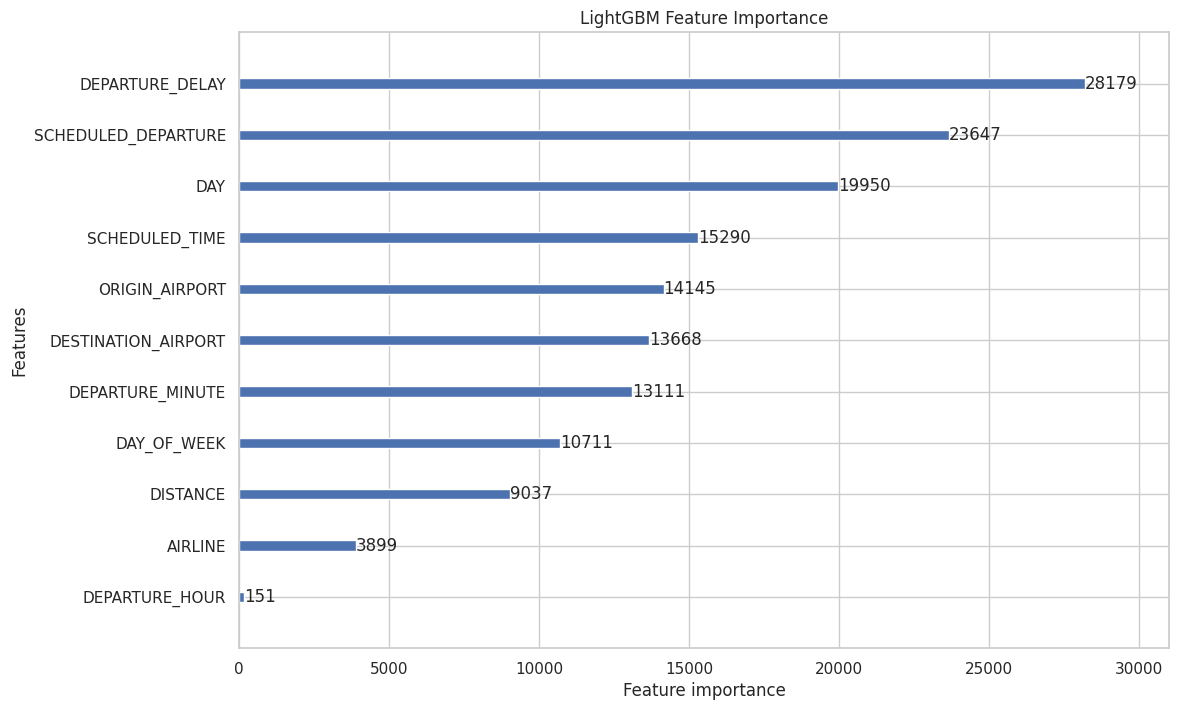

In [ ]:
# --- Make Predictions on the Test Set ---
y_pred = final_model.predict(X_test)

# --- Evaluate the Model ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2 Score): {r2}")

# --- Feature Importance ---
plt.figure(figsize=(12, 8))
lgb.plot_importance(final_model, max_num_features=20)
plt.title('LightGBM Feature Importance')
plt.show()